### Desenvolvendo o modelo

In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(".."))
from src import plot_utils as plu
from dotenv import load_dotenv ; load_dotenv()

from sklearn.metrics import (roc_auc_score, 
                             average_precision_score, 
                             classification_report, 
                             confusion_matrix)
from src.model_utils import (create_pipeline,
                             create_training_pipeline,
                             plot_rfe_train_scores,
                             create_columns_listing,
                             plot_precision_recall_and_roc,
                             plot_dist,
                             plot_decision_tree_and_importance,
                             impact,
                             impact_grouped,
                             calculate_simple_gains)

from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve, RocCurveDisplay
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree            
from sklearn.pipeline import Pipeline, FeatureUnion
from lightgbm import LGBMClassifier, early_stopping   
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df_model = pd.read_csv('../data/gold_dados_stone.csv')

# Dropando colunas que não vou utilizar no modelo
df_model.drop([
    'Unnamed: 0', # Index
    'Hora',
    'Cartão',
    'weekday',
    'dia_hora',
    'mean_shift_customer_no_cbk', 
    'mean_shift_customer_cbk',
    'mean_weekday_num_customer_no_cbk', 
    'mean_weekday_num_customer_cbk',
    'mean_days_operations_customer_no_cbk',
    'mean_days_operations_customer_cbk', 
    'last_day_no_cbk', 
    'last_day_cbk',
    'last_two_minutes_no_cbk_ops', 
    'last_two_minutes_cbk_ops',
    'last_five_minutes_no_cbk_ops', 
    'last_five_minutes_cbk_ops',
    'qtd_cbk_operations_15d',
    'last_purchase_time_between'
],axis=1,inplace=True)

df_model['CBK'] = np.where(df_model['CBK'] == "Sim",1,0)

# Selecionando o dataframe
X_full = df_model[df_model['label'] == 'trainer']

# Base de treinamento
X_train = X_full[X_full['Dia'] <= '2015-05-23']
y_train = X_train['CBK']
X_train = X_train.drop(['CBK','label','Dia'],axis=1)

# Base de validação
X_val = X_full[X_full['Dia'] > '2015-05-23']
y_val = X_val['CBK']
X_val = X_val.drop(['CBK','label','Dia'],axis=1)

# Base de payload
X_payload = df_model[df_model['label'] == 'payload']
y_payload = X_payload['CBK']
X_payload = X_payload.drop(['CBK','label','Dia'],axis=1)

c:\Users\vinic\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Badrate

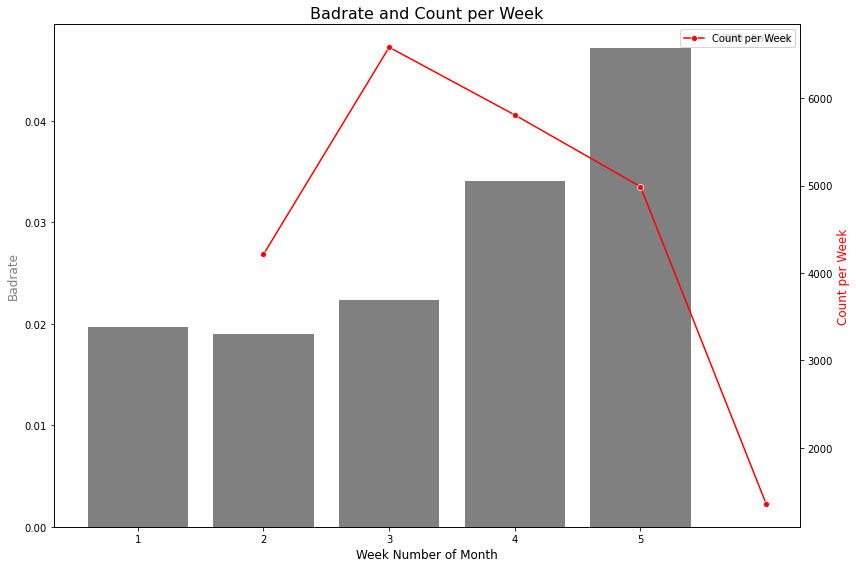

In [3]:
df_plot = plu.plot_badrate(df=df_model)

In [4]:
df_model['label'] = df_model.apply(lambda x: 
            'train' if x['Dia'] <= '2015-05-23' else 
            ('val' if x['Dia'] < '2015-06-01' and x['Dia'] > '2015-05-23' else 'test')
        ,axis=1)

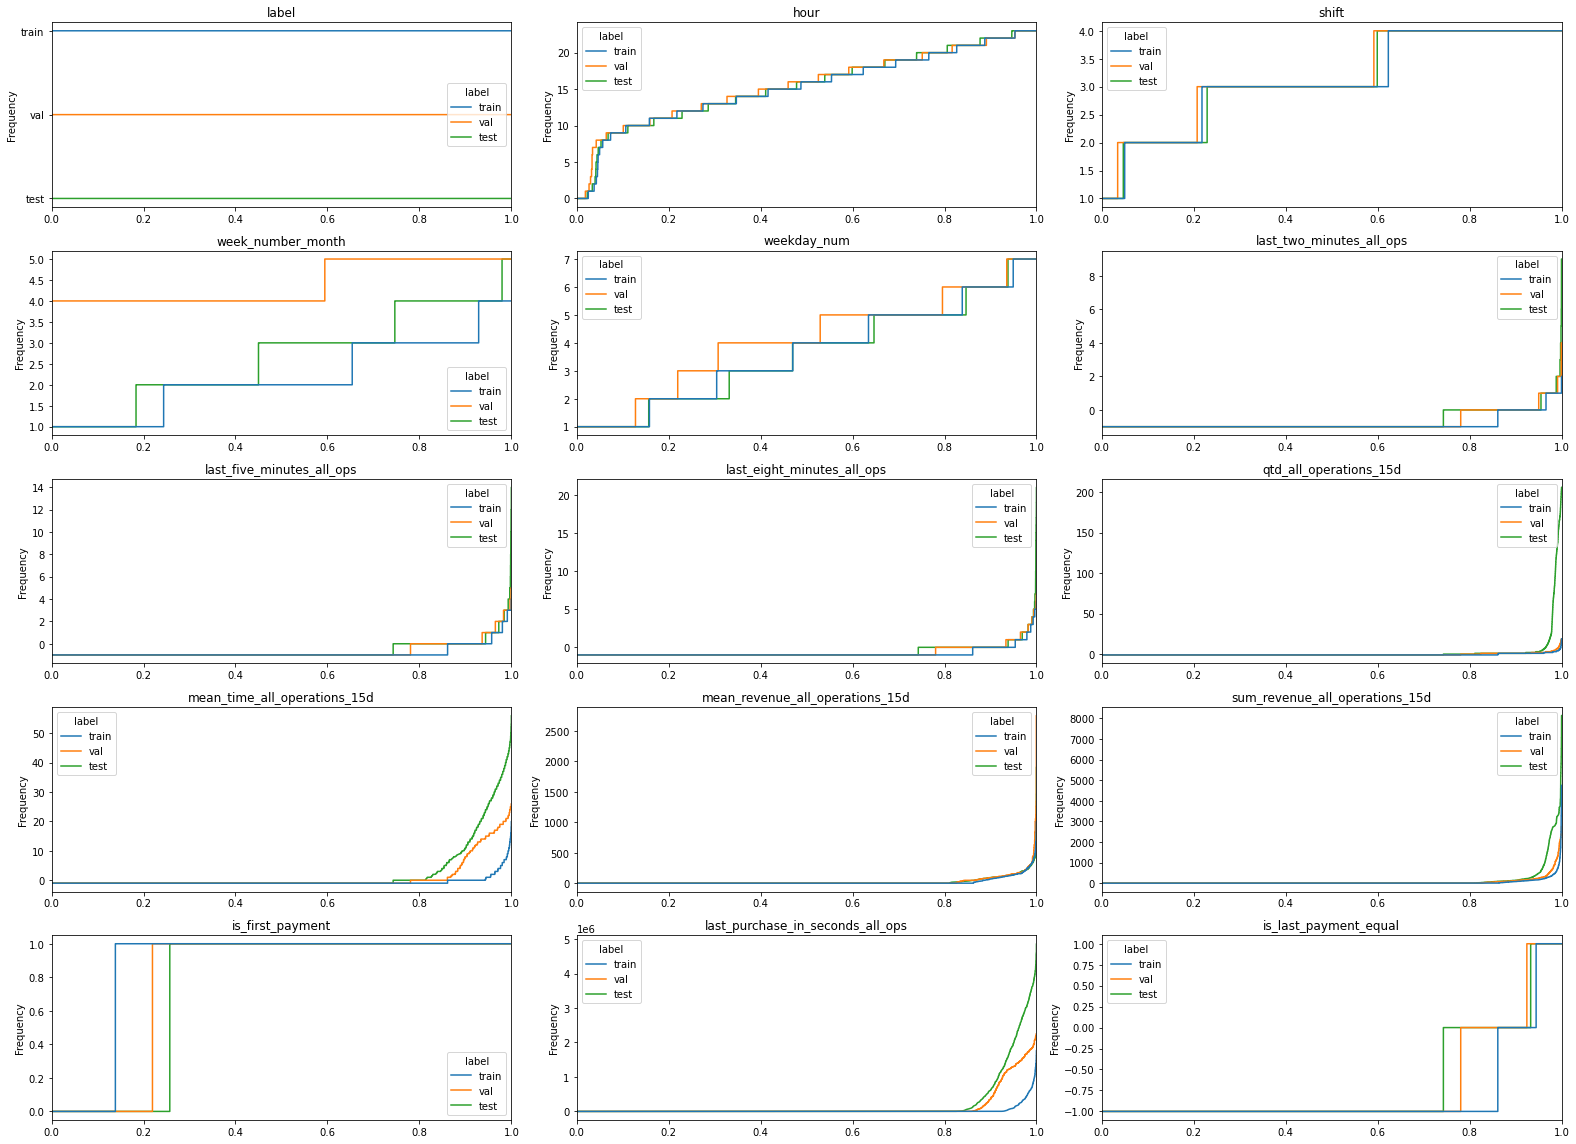

In [5]:
plu.plotar_ecdf_split(df=df_model[[
    'label', 'hour', 'shift', 'week_number_month',
    'weekday_num', 'last_two_minutes_all_ops', 'last_five_minutes_all_ops',
    'last_eight_minutes_all_ops', 'qtd_all_operations_15d',
    'mean_time_all_operations_15d', 'mean_revenue_all_operations_15d',
    'sum_revenue_all_operations_15d', 'is_first_payment',
    'last_purchase_in_seconds_all_ops', 'is_last_payment_equal'
]])

In [6]:
pipe_prep_features, numerical_features, one_hot_features, ordinal_features = create_pipeline(
    df=X_train,
    ordinal_order={
        'shift':[1,2,3],
        'weekday_num':[1,2,3,4],
        'week_number_month':[1,2,3]
    },
    columns_ignore=[], # Sem nenhuma coluna para ignorar
    numerical_scaler=None
)

cv = StratifiedShuffleSplit(n_splits = 3, test_size = 0.3, random_state = 42)

pipe = Pipeline([
    ('transformer_prep', pipe_prep_features),
    ('estimator', RFECV(estimator=DecisionTreeClassifier(random_state=42),
                step=1,
                min_features_to_select=1,
                cv=cv,
                verbose=1,
                scoring='average_precision'))
])
pipe.fit(X_train, y_train)

Ignorando essas colunas tanto para OneHot quanto para Numerical: ['shift', 'weekday_num', 'week_number_month']
DataFrames criados sendo numericas:12, one_hot:0, ordinal:3
Pipelines criados, criando of FeatureUnion
[FeatureUnion] ...... (step 1 of 2) Processing pipe_num, total=   0.0s
[FeatureUnion] ...... (step 2 of 2) Processing pipe_ord, total=   0.0s
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitt

Pipeline(steps=[('transformer_prep',
                 FeatureUnion(transformer_list=[('pipe_num',
                                                 Pipeline(steps=[('selector_numerical',
                                                                  ColumnTransformer(transformers=[('filter_num_cols',
                                                                                                   'passthrough',
                                                                                                   array(['Valor', 'hour', 'last_two_minutes_all_ops',
       'last_five_minutes_all_ops', 'last_eight_minutes_all_ops',
       'qtd_all_operations_15d', 'mean_time_all_operations_15d',
       'mean_...
                                                                 ('one_imputer',
                                                                  SimpleImputer(strategy='most_frequent')),
                                                                 ('OrdinalEncoder',
                                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                 unknown_value=-1))]))],
                              verbose=True)),
                ('estimator',
                 RFECV(cv=StratifiedShuffleSplit(n_splits=3, random_state=42, test_size=0.3,
            train_size=None),
                       estimator=DecisionTreeClassifier(random_state=42),
                       scoring='average_precision', verbose=1))])

Número ótimo de features: 1
Ranking das features [ 2  3 14  1  9 10 12  6  7 15  4 13 11  5  8]


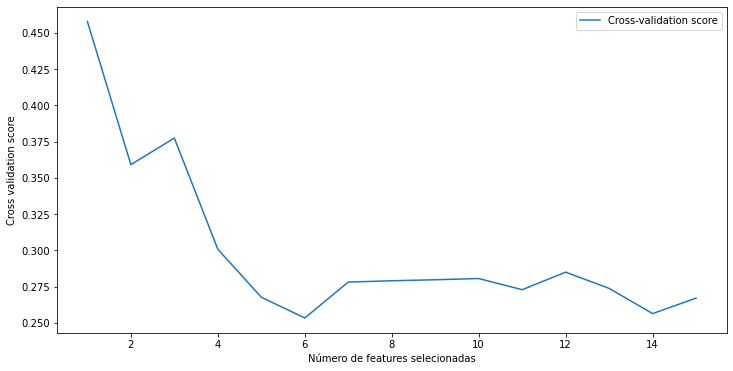

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score
0,0.457835,0.006297,0.451209,0.455994,0.466301
1,0.359100,0.074732,0.452926,0.270059,0.354313
2,0.377405,0.037679,0.368661,0.336255,0.427299
3,0.300758,0.021779,0.288137,0.331400,0.282736
4,0.267662,0.008185,0.274976,0.256236,0.271775
5,0.253344,0.022902,0.223960,0.279835,0.256236
6,0.278107,0.008257,0.270782,0.289645,0.273894
7,0.279008,0.010249,0.264680,0.288071,0.284272
8,0.279711,0.021633,0.249475,0.298865,0.290794
9,0.280544,0.019721,0.255179,0.303268,0.283186


Features que o RFECV recomenda:
['pipe_num__filter_num_cols__last_five_minutes_all_ops']


({'rows/index': 'As rows são as features sendo excluidas recursivamente',
  'colunas': 'Possuimos o valor do teste médio assim o resultado individual de cada teste, quanto mais cv mais colunas'},
 array(['pipe_num__filter_num_cols__last_five_minutes_all_ops'],
       dtype=object))

In [7]:
plot_rfe_train_scores(pipe)

In [10]:
y_label = pipe.predict(X_val)
print(classification_report(y_true=y_val, y_pred=y_label))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2579
           1       0.75      0.41      0.53       174

    accuracy                           0.95      2753
   macro avg       0.86      0.70      0.75      2753
weighted avg       0.95      0.95      0.95      2753



### Se quisermos usar o resultado do RFE

In [5]:
transformed_features = pipe.named_steps['transformer_prep'].get_feature_names_out()
selected_features = transformed_features[pipe.named_steps['estimator'].support_]
features = create_columns_listing(selected_features)

X_train = X_train[features]
X_val = X_val[features]
X_payload = X_payload[features]

['pipe_num__filter_num_cols__last_five_minutes_all_ops']


### Alterando levemente o resultado do RFECV

In [3]:
X_train = X_train[[
    'last_five_minutes_all_ops',
    'last_purchase_in_seconds_all_ops',
    'is_last_payment_equal',
    'is_first_payment',
    'sum_revenue_all_operations_15d'
]]

In [4]:
pipe_prep_features, _, __, ___ = create_pipeline(
    df=X_train,
    columns_ignore=[],
    numerical_scaler=None
)

pipe_tuning = Pipeline([
    ('transformer_prep', pipe_prep_features),
    ('estimator',DecisionTreeClassifier())
])

cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.3, random_state = 42)
metric = 'average_precision'

params = {
    'estimator__criterion':['entropy','gini'],
    'estimator__max_depth':[2,3,4,5,6,7,8],
    'estimator__min_samples_split':[2,3,4,5],
    'estimator__min_samples_leaf':[1,2,3,4,5],
    'estimator__class_weight':['balanced'],
    'estimator__random_state':[42]
}

random_search = RandomizedSearchCV(
    estimator= pipe_tuning,
    param_distributions=params,
    n_iter=200,
    scoring=metric,
    refit=True,
    cv=3,
    random_state=42,
    error_score='raise'
)

random_search.fit(X_train, 
                  y_train)

print('####################')
print(random_search.best_score_)
print(random_search.best_params_)

y_pred = random_search.predict_proba(X_val)[:, 1]
y_pred_train = random_search.predict_proba(X_train)[:, 1]

Ignorando essas colunas tanto para OneHot quanto para Numerical: []
DataFrames criados sendo numericas:5, one_hot:0, ordinal:0
Pipelines criados, criando of FeatureUnion
[FeatureUnion] ...... (step 1 of 1) Processing pipe_num, total=   0.0s
[FeatureUnion] ...... (step 1 of 1) Processing pipe_num, total=   0.0s
[FeatureUnion] ...... (step 1 of 1) Processing pipe_num, total=   0.0s
[FeatureUnion] ...... (step 1 of 1) Processing pipe_num, total=   0.0s
[FeatureUnion] ...... (step 1 of 1) Processing pipe_num, total=   0.0s
[FeatureUnion] ...... (step 1 of 1) Processing pipe_num, total=   0.0s
[FeatureUnion] ...... (step 1 of 1) Processing pipe_num, total=   0.0s
[FeatureUnion] ...... (step 1 of 1) Processing pipe_num, total=   0.0s
[FeatureUnion] ...... (step 1 of 1) Processing pipe_num, total=   0.0s
[FeatureUnion] ...... (step 1 of 1) Processing pipe_num, total=   0.0s
[FeatureUnion] ...... (step 1 of 1) Processing pipe_num, total=   0.0s
[FeatureUnion] ...... (step 1 of 1) Processing pi

### ROC-auc e PR-auc

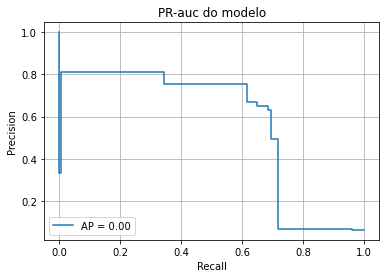

In [5]:
precision, recall, _ = precision_recall_curve(y_val, y_pred)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=False)
pr_display.plot()
plt.title('PR-auc do modelo')
plt.grid()
plt.show()

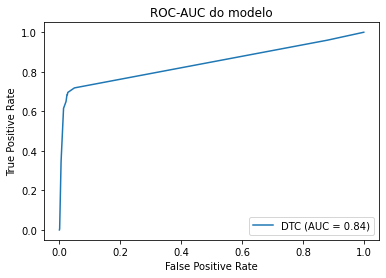

In [6]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='DTC')
display.plot()
plt.title('ROC-AUC do modelo')
plt.show()

In [11]:
y_label = random_search.predict(X_val)
print(classification_report(y_true=y_val, y_pred=y_label))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2579
           1       0.63      0.70      0.66       174

    accuracy                           0.95      2753
   macro avg       0.80      0.83      0.82      2753
weighted avg       0.96      0.95      0.96      2753



c:\Users\vinic\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\vinic\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\vinic\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

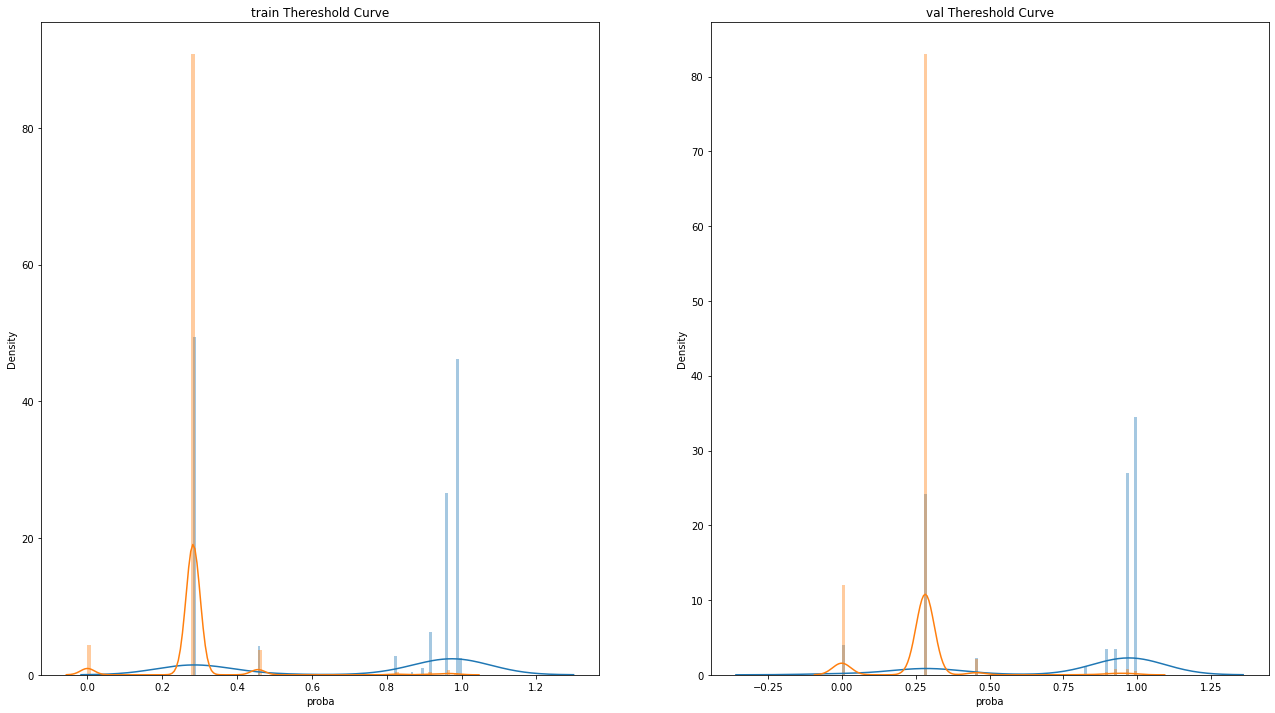

In [12]:
plot_dist(y_train=y_train, pred_proba_train=y_pred_train,
          y_val=y_val, pred_proba_val=y_pred)

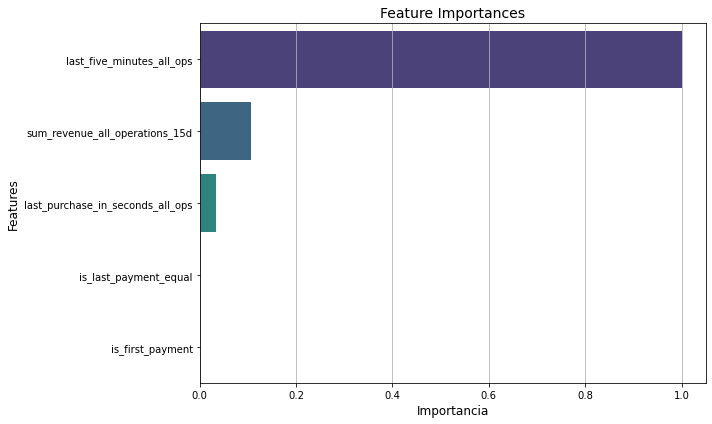

In [13]:
plot_decision_tree_and_importance(pipe=random_search, X_train=X_train)

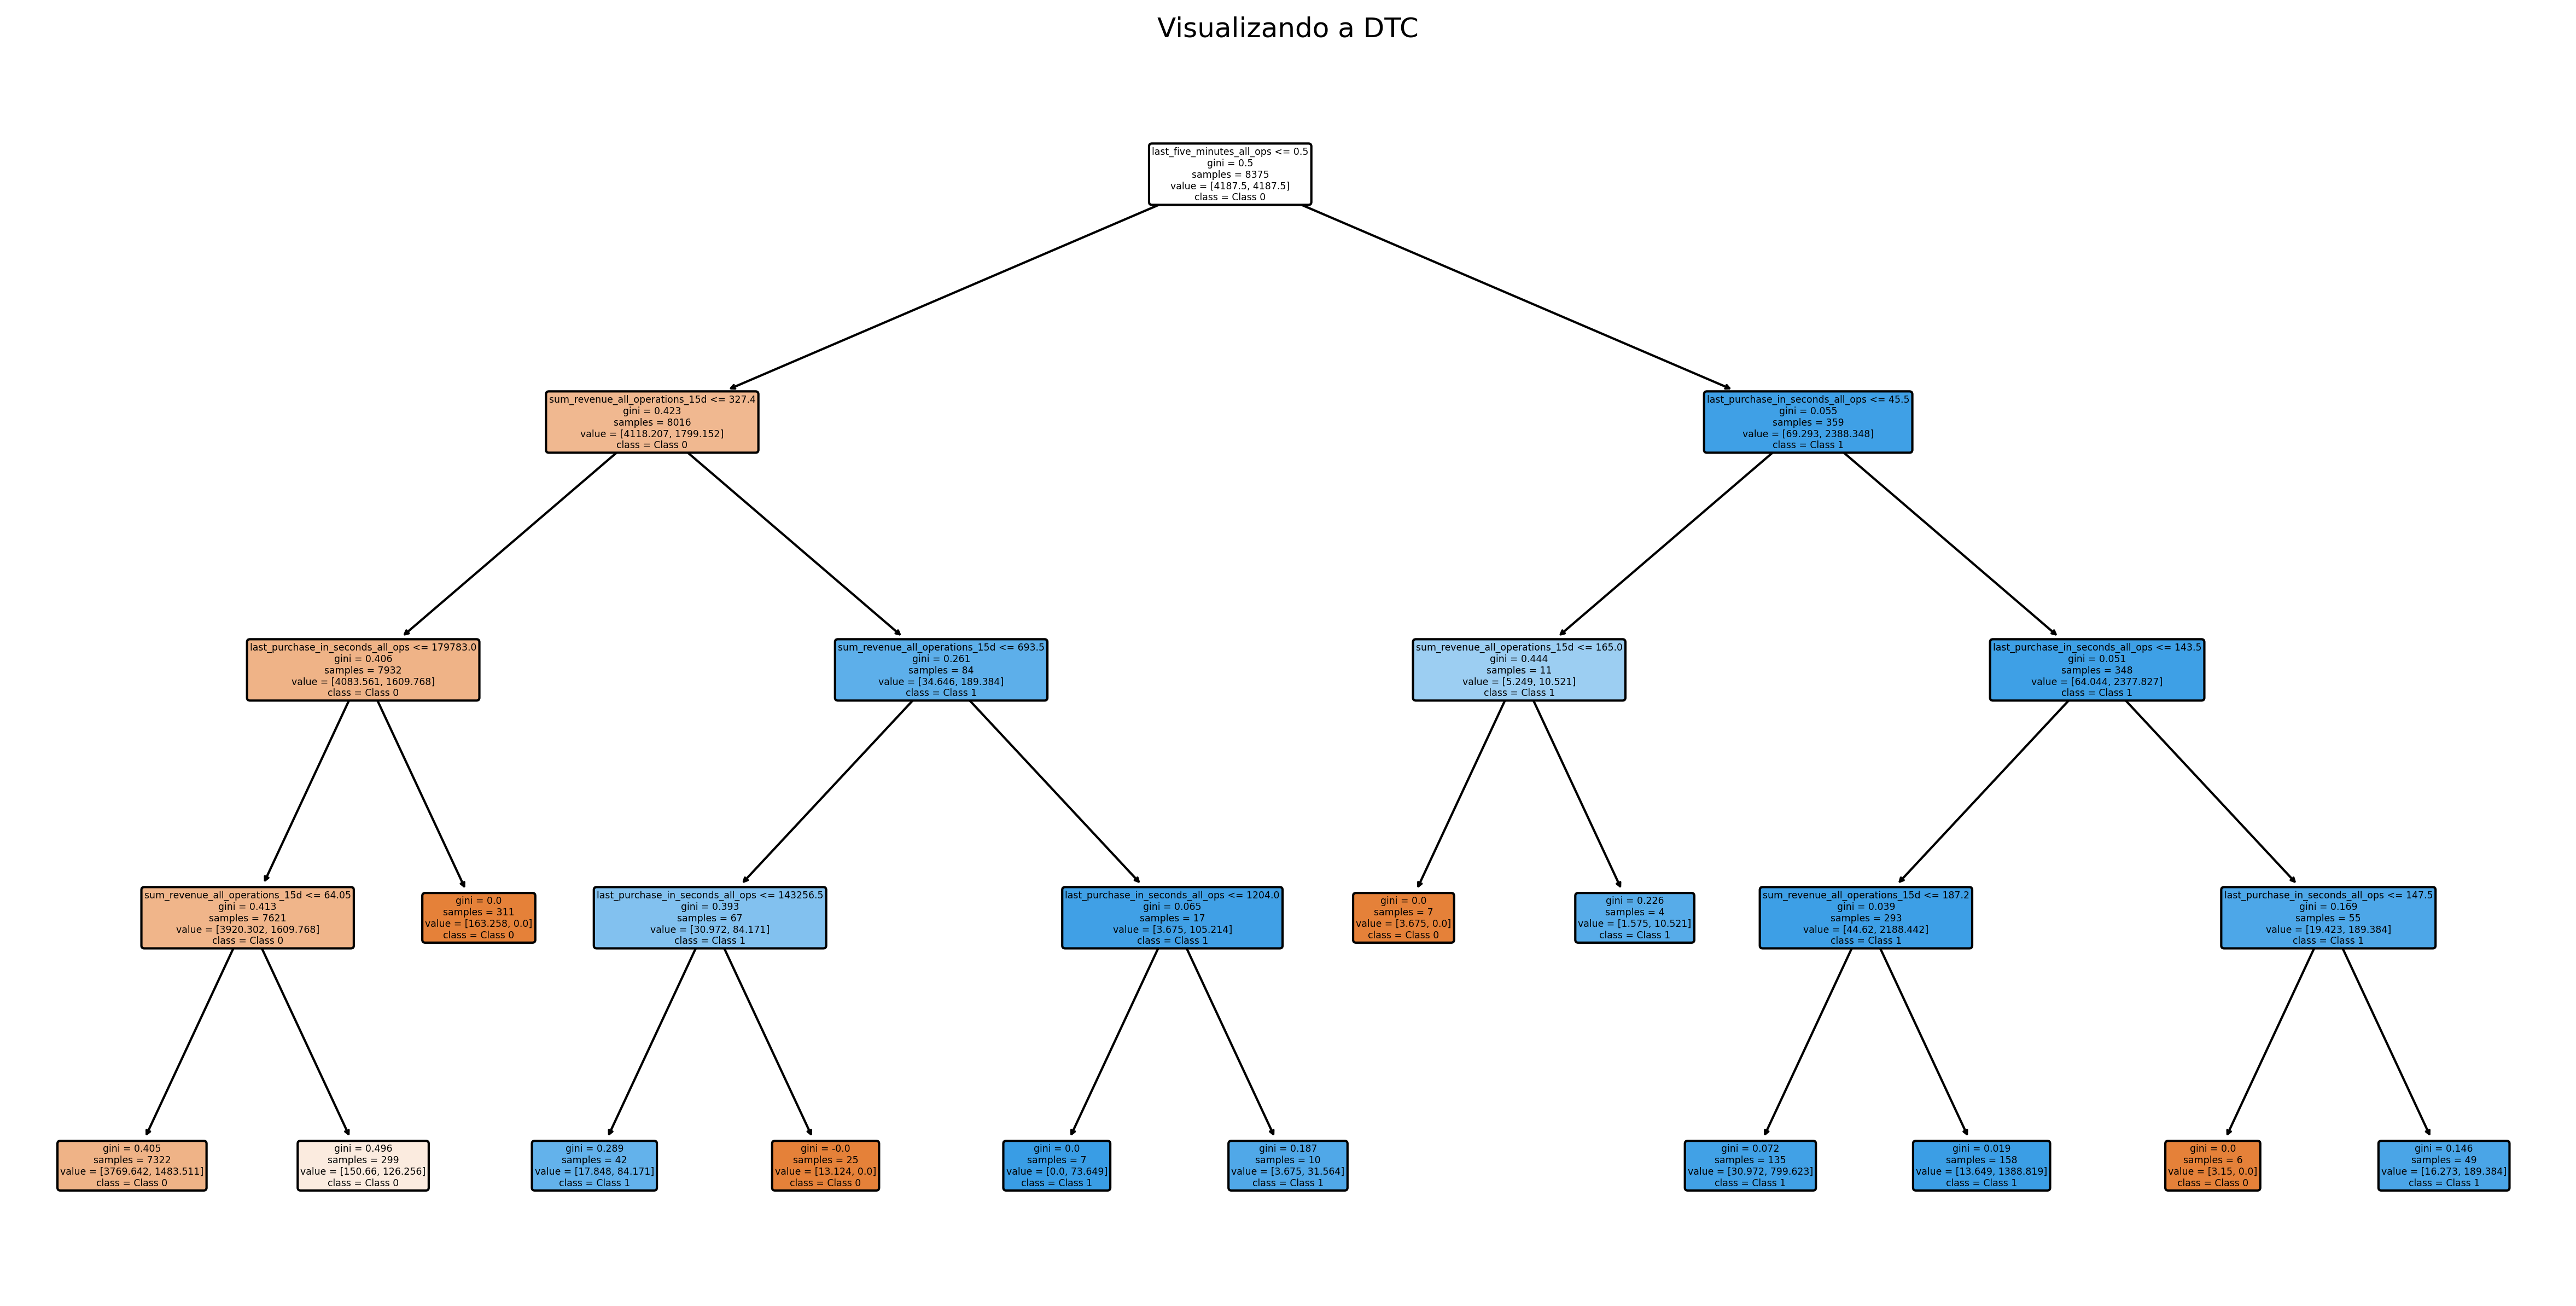

In [14]:
best_tree = random_search.best_estimator_.named_steps['estimator']

plt.figure(figsize=(20, 10),dpi=300)
plot_tree(
    best_tree, 
    feature_names=X_train.columns,
    class_names=['Class 0', 'Class 1'],
    filled=True, 
    rounded=True
)
plt.title("Visualizando a DTC")
plt.show()

In [7]:
y_val.name = 'chargeback_dispute_status'
impact_grouped(target=y_val, predicted_probabilities=y_pred, X_set=X_val, y_set=y_val)

,score_interval,volumetria,acertos,volumetria_acc,acertos_acc,erros,erros_acc,prec_linha,recall_linha,percent_impact,percent_error,percent_acertos,prec_acc,recall_acc
20,"(0.95,1.00]",142,107,142.0,107.0,35,35.0,0.632555,0.321839,5.158009,1.357115,61.494253,0.753521,0.614943
19,"(0.90,0.95]",27,6,169.0,113.0,21,56.0,0.668639,0.649425,6.138758,2.171384,64.942529,0.668639,0.649425
18,"(0.85,0.90]",17,6,186.0,119.0,11,67.0,0.645029,0.683908,6.756266,2.597906,68.390805,0.639785,0.683908
17,"(0.80,0.85]",6,2,192.0,121.0,4,71.0,0.630208,0.695402,6.974210,2.753005,69.540230,0.630208,0.695402
16,"(0.75,0.80]",0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,"(0.70,0.75]",0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,"(0.65,0.70]",0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,"(0.60,0.65]",0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,"(0.55,0.60]",0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,"(0.50,0.55]",0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Escolha do Threshold não interfere muito nas métricas de precision e recall.

* Podemos ser mais conservadores mantendo um threshold mais alto como 0.7
* Podemos ser mais flexíveis mantendo um threshold de 0.55 por exemplo

In [15]:
y_pred_proba = random_search.predict_proba(X_val)[:, 1]
threshold = 0.85
y_label = (y_pred_proba >= threshold).astype(int)
print(classification_report(y_true=y_val, y_pred=y_label))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2579
           1       0.64      0.68      0.66       174

    accuracy                           0.96      2753
   macro avg       0.81      0.83      0.82      2753
weighted avg       0.96      0.96      0.96      2753



In [16]:
y_pred_proba = random_search.predict_proba(X_val)[:, 1]
threshold = 0.5
y_label = (y_pred_proba >= threshold).astype(int)
print(classification_report(y_true=y_val, y_pred=y_label))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2579
           1       0.63      0.70      0.66       174

    accuracy                           0.95      2753
   macro avg       0.80      0.83      0.82      2753
weighted avg       0.96      0.95      0.96      2753



### Salvando os dados preditos

In [ ]:
df_model = pd.read_csv('../data/gold_dados_stone.csv')

y_pred_payload = random_search.predict_proba(X_payload)[:, 1]
threshold = 0.55
y_pred_payload_wright = (y_pred_payload >= threshold).astype(int)

c:\Users\vinic\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [25]:
df_payload = df_model[df_model['label'] == 'payload']
df_payload['CBK'] = y_pred_payload_wright
df_payload['score_modelo'] = y_pred_payload * 1000

path_start = os.getenv("PATH_START")
df_payload[[
    'Dia', 
    'Hora', 
    'Valor', 
    'Cartão', 
    'CBK',
    'score_modelo'
]].to_excel(f"{path_start}data\\payload_predictions.xlsx")

C:\Users\vinic\AppData\Local\Temp/ipykernel_3564/256494998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['CBK'] = y_pred_payload_wright
C:\Users\vinic\AppData\Local\Temp/ipykernel_3564/256494998.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['score_modelo'] = y_pred_payload * 1000


In [5]:
import pickle

# Salvando o modelo com o pipeline.
with open('model_oficial.pkl', 'wb') as file:
    pickle.dump(random_search, file)

### Calculando os ganhos na base de validação

In [5]:
y_pred_proba = random_search.predict_proba(X_val)[:, 1]
threshold = 0.55
y_label = (y_pred_proba >= threshold).astype(int)
print(classification_report(y_true=y_val, y_pred=y_label))

df_val = X_val.copy()
df_val['y_true'] = y_val
df_val['y_pred'] = y_label

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2579
           1       0.63      0.70      0.66       174

    accuracy                           0.95      2753
   macro avg       0.80      0.83      0.82      2753
weighted avg       0.96      0.95      0.96      2753



In [6]:
calculate_simple_gains(df=df_val)

####################################### RESULTADOS POSITIVOS #####################################
Valor que o modelo identificou: 17237.920000000002
Rate do valor monetário que o modelo inteferiu: 0.68
Qtd de casos inteferidos pelo modelo 121
Rate de casos que o modelo inteferiu do total 0.7
##################################################################################################


####################################### RESULTDOS NEGATIVOS ######################################
Valor que o modelo determinou erroneamente como CBK 15465.93
Valor que o modelo determinou erroneamente que não era CBK 8051.27
Qtd de casos em que o modelo determinou erroneamente como CBK 71
Qtd de casos em que o modelo determinou erroneamente que não era CBK 53
##################################################################################################


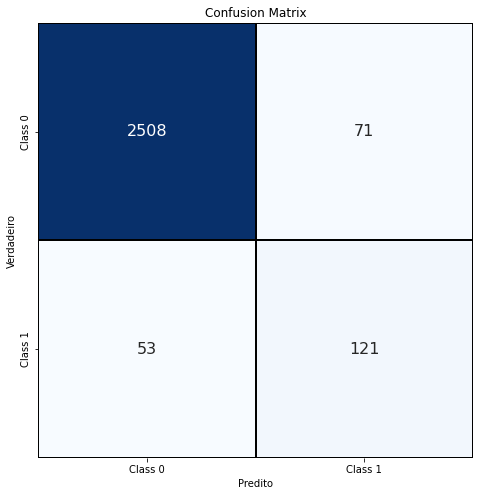

In [17]:
import seaborn as sns

cm = confusion_matrix(y_true=y_val, y_pred=y_label)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'],
            cbar=False, linewidths=2, linecolor='black', annot_kws={"size": 16}, square=True)
plt.title('Confusion Matrix')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()